# Utils

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
from lab1_utils import train_loop, train, test, get_lr
from lab1_utils import multiple_diagnostic, test_class

Define a basic network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 13 * 13, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(x.shape)
        x = self.pool(self.relu(self.conv1(x)))
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.relu(self.conv3(x))
        # x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        # print(x.shape)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.relu(self.fc2(x))
        # print(x.shape)
        x = self.relu(self.fc3(x))
        # print(x.shape)
        x = self.fc4(x)  # logits
        # print(x.shape)
        return x

In [5]:
mod = Net()
print(summary(mod))
mod(torch.randn(1, 3, 32, 32))

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            168
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            880
├─Conv2d: 1-4                            4,640
├─Linear: 1-5                            1,384,704
├─Linear: 1-6                            32,896
├─Linear: 1-7                            8,256
├─Linear: 1-8                            650
├─ReLU: 1-9                              --
Total params: 1,432,194
Trainable params: 1,432,194
Non-trainable params: 0
torch.Size([1, 3, 32, 32])
torch.Size([1, 6, 17, 17])
torch.Size([1, 16, 15, 15])
torch.Size([1, 32, 13, 13])
torch.Size([1, 5408])
torch.Size([1, 256])
torch.Size([1, 128])
torch.Size([1, 64])
torch.Size([1, 10])


tensor([[ 0.0402, -0.0297, -0.0745,  0.1085, -0.0789,  0.0017,  0.0657, -0.0633,
         -0.0034, -0.1332]], grad_fn=<AddmmBackward0>)

In [17]:
def train(model, device, train_loader, criterion, optimizer):
    model.train()

    losses, accs = [], []
    correct = 0.

    for batch_idx, (data, target) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # prediction
        pred = output.argmax(dim=1, keepdim=True)
        correct = torch.eq(pred, target.view_as(pred)).float()
        acc = torch.mean(correct)

        losses.append(loss.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())

    loss_k = np.array(losses).mean()
    acc_k = np.array(accs).mean()

    return loss_k, acc_k

In [19]:
def test(model, device, criterion, test_loader):
    model.eval()  # configura il modello in evaluation mode

    losses, accs = [], []
    correct = 0.

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            ## Compute loss
            output = model(data)
            loss = criterion(output, target)

            ## Prediction
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = torch.eq(pred, target.view_as(pred)).float()
            # correct += pred.eq(target.view_as(pred)).sum().item()
            acc = torch.mean(correct)

            ## Update loss and accuracy
            losses.append(loss.detach().cpu().numpy())
            accs.append(acc.detach().cpu().numpy())

    loss_k = np.array(losses).mean()
    acc_k = np.array(accs).mean()

    return loss_k, acc_k

In [31]:
def train_loop(train_loader, test_loader, model, criterion, device,
               lr, momentum, max_epochs, do_test=True):

    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    losses_train, accs_train = [], []
    losses_test, accs_test = [], []
    
    _start = time.time()
    _epoch_time = time.time()

    for epoch in range(1, max_epochs + 1):
        loss_train, acc_train = train(model, device, train_loader, criterion, optimizer)
        print(f"Epoch: {epoch}, Learning rate: {get_lr(optimizer):.6f}")
        print(f"Training - Loss: {loss_train:.4f}, Accuracy: {acc_train:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
        losses_train.append(loss_train)
        accs_train.append(acc_train)

        if do_test:
            loss_test, acc_test = test(model, device, criterion, test_loader)
            losses_test.append(loss_test)
            accs_test.append(acc_test)
            print(f"Test - Loss: {loss_test:.4f}, Accuracy: {acc_test:.2f}")

        _epoch_time = time.time()

    _end = time.time()
    print(f"Done! - Runtime: {(_end-_start):.2f} seconds")

    test_class(model, device, criterion, testloader)

    if do_test:
        return losses_train, accs_train, losses_test, accs_test
    else:
        return losses_train, accs_train

In [3]:
def test_class(model, device, criterion, test_loader):
    model.eval()  # configura il modello in evaluation mode

    # prepare to count predictions for each class
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    losses, accs = [], []
    correct = 0.

    with torch.no_grad():
        for data, target in test_loader:
            data, targets = data.to(device), target.to(device)

            ## Fit data
            output = model(data)

            ## Prediction
            preds = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for target, pred in zip(targets, preds):
                if target == pred:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Exercise 0

In [4]:
# without normalization
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
mean = torch.zeros(3)  # a mean for each channel, here 1
std = torch.zeros(3)  # a std for each channel, here 1
samples = 0

# simple because we only have one channel, that is greyscale
for X, y in trainloader:
    # width and height over one dimension
    X = torch.flatten(X, 2, 3)
    # compute mean and std over each channel then sum and store
    mean += X.mean(2).sum(0)
    std += X.std(2).sum(0)
    samples += X.size(0)

print(f"Samples {samples}")
mean /= samples
print(f"Mean {mean}")
std /= samples
print(f"Std {std}")

Samples 50000
Mean tensor([0.4914, 0.4822, 0.4465])
Std tensor([0.2023, 0.1994, 0.2010])


In [6]:
# normalize data correctly
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Exercise 1
Learning rate scheduler

In [7]:
max_epochs = 20

In [9]:
def simple_diagnostic(max_epochs, losses_train, accs_train):
    epochs_seq = np.arange(1, max_epochs + 1)
    # epoch_labels = 

    # plot only training loss and accuracy
    fig, ax = plt.subplots()
    # fig.suptitle("Training performance")
    fig.suptitle("Training loss and accuracy againts epochs")

    color = "tab:blue"
    ax.plot(epochs_seq, losses_train, label="loss", color=color)
    # ax.set_title("Training loss and accuracy againts epochs")
    ax.grid("both")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss", color=color)
    ax.tick_params(axis="y", labelcolor=color)
    ax.set_xticks(np.arange(1, max_epochs+1, step=2))
    ax.set_xticklabels(np.arange(1, max_epochs + 1, 2))

    color = "tab:red"
    ax_1 = ax.twinx()
    ax_1.plot(epochs_seq, accs_train, label="accuracy", color="tab:red")
    ax_1.set_ylabel("Accuracy", color="tab:red")
    ax_1.tick_params(axis="y", labelcolor=color)

In [10]:
def multiple_diagnostic_single(loss_acc_dict):
    # loss_acc_dict = {"Solver1": [loss, acc]...}
    epochs_seq = np.arange(1, max_epochs + 1)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

    fig, ax = plt.subplots()
    ax_1 = ax.twinx()
    # fig.suptitle("CNN training performance over CIFAR10")
    fig.suptitle("Training loss and accuracy againts epochs")

    for i, (solver_name, perf) in enumerate(loss_acc_dict.items()):

        color = colors[i]
        ## plot loss function performance
        ax.plot(epochs_seq, perf[0], label=solver_name, color=color)
        ax.grid("both")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.tick_params(axis="y")
        ax.set_xticks(np.arange(1, max_epochs+1, step=2))
        ax.set_xticklabels(np.arange(1, max_epochs + 1, 2))

        ## plot accuracy performance
        ax_1.plot(epochs_seq, perf[1], label=solver_name, color=color)
        ax_1.set_ylabel("Accuracy")
        ax_1.tick_params(axis="y")

    ax.legend()

In [37]:
def multiple_diagnostic(loss_acc_dict, max_epochs=10, title_left="Training loss against epochs",
                       title_right="Test accuracy against epochs"):
    # loss_acc_dict = {"Solver1": [loss, acc]...}
    epochs_seq = np.arange(1, max_epochs + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
    # fig.suptitle("CNN training performance over CIFAR10")

    for solver_name, perf in loss_acc_dict.items():

        # plot loss function performance
        axs[0].plot(epochs_seq, perf[0], label=solver_name)
        axs[0].grid("both")
        axs[0].set_title(title_left)

        # plot accuracy performance
        axs[1].plot(epochs_seq, perf[1], label=solver_name)
        axs[1].grid("both")
        axs[1].set_title(title_right)

    axs[0].legend()
    axs[1].legend()

In [8]:
es1_loss_acc = {}  # {"Solver1": [loss, acc]}
criterion = torch.nn.CrossEntropyLoss()  # input requires logits

## Basic training

In [9]:
model1 = Net()
model1.to(device)

model1_dict = dict(model=model1, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                   max_epochs=max_epochs, do_test=True)

stats = train_loop(trainloader, testloader, **model1_dict)

es1_loss_acc["SGD"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.3017, Accuracy: 0.13, Runtime: 10.05
Test - Loss: 2.2973, Accuracy: 0.16
Epoch: 2, Learning rate: 0.001000
Training - Loss: 2.2160, Accuracy: 0.20, Runtime: 9.63
Test - Loss: 2.0567, Accuracy: 0.26
Epoch: 3, Learning rate: 0.001000
Training - Loss: 1.8654, Accuracy: 0.33, Runtime: 9.53
Test - Loss: 1.7061, Accuracy: 0.38
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.6323, Accuracy: 0.40, Runtime: 9.72
Test - Loss: 1.5762, Accuracy: 0.42
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.5357, Accuracy: 0.44, Runtime: 9.35
Test - Loss: 1.4795, Accuracy: 0.46
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.4482, Accuracy: 0.48, Runtime: 9.45
Test - Loss: 1.3964, Accuracy: 0.50
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.3565, Accuracy: 0.51, Runtime: 9.34
Test - Loss: 1.3469, Accuracy: 0.52
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.2723, Accuracy: 0.55, Runtime: 9.30
Test - Loss: 1.3087, Accuracy: 0.53

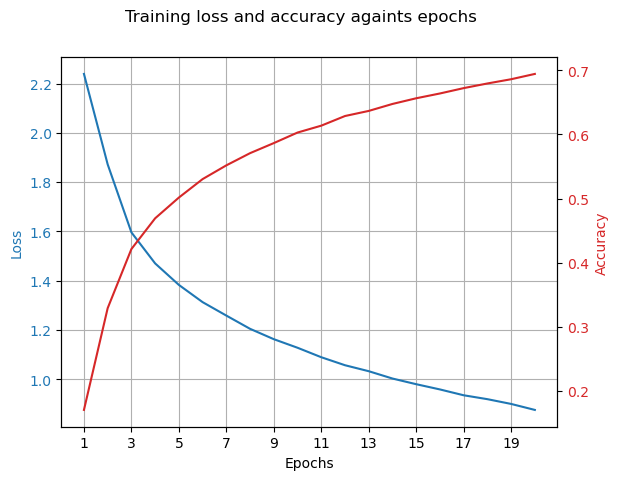

In [29]:
simple_diagnostic(max_epochs, stats[0], stats[1])
plt.savefig("./plots/es1-sgd.pdf")

## Multi-step scheduler

In [11]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ExponentialLR

In [17]:
model2 = Net()
model2.to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.08, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()
for epoch in range(max_epochs):
    ## train
    loss_train, acc_train = train(model2, device, trainloader, criterion, optimizer)
    print(f"Epoch: {epoch+1}, Learning rate: {get_lr(optimizer):.6f}")
    print(f"Training - Loss: {loss_train:.4f}, Accuracy: {acc_train:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
    losses.append(loss_train)
    scheduler.step()
    ## test
    loss_test, acc_test = test(model2, device, criterion, testloader)
    accs.append(acc_test)
    print(f"Test - Loss: {loss_test:.4f}, Accuracy: {acc_test:.2f}")
    _epoch_time = time.time()
print(f"Runtime: {(time.time() - _start):.2f} seconds")

es1_loss_acc["SGD-Step"] = [losses, accs]

test_class(model2, device, criterion, testloader, classes)

Epoch: 0, Learning rate: 0.080000
Training - Loss: 1.9195, Accuracy: 0.28, Runtime: 9.30
Test - Loss: 1.7999, Accuracy: 0.35
Epoch: 1, Learning rate: 0.080000
Training - Loss: 1.6987, Accuracy: 0.38, Runtime: 9.08
Test - Loss: 1.7047, Accuracy: 0.37
Epoch: 2, Learning rate: 0.080000
Training - Loss: 1.6831, Accuracy: 0.39, Runtime: 9.21
Test - Loss: 1.7477, Accuracy: 0.35
Epoch: 3, Learning rate: 0.080000
Training - Loss: 1.6617, Accuracy: 0.41, Runtime: 9.24
Test - Loss: 1.7031, Accuracy: 0.39
Epoch: 4, Learning rate: 0.080000
Training - Loss: 1.6757, Accuracy: 0.40, Runtime: 9.21
Test - Loss: 1.6998, Accuracy: 0.39
Epoch: 5, Learning rate: 0.080000
Training - Loss: 1.6943, Accuracy: 0.40, Runtime: 9.28
Test - Loss: 1.7053, Accuracy: 0.41
Epoch: 6, Learning rate: 0.080000
Training - Loss: 1.7231, Accuracy: 0.39, Runtime: 9.14
Test - Loss: 1.8044, Accuracy: 0.34
Epoch: 7, Learning rate: 0.080000
Training - Loss: 1.7687, Accuracy: 0.36, Runtime: 9.19
Test - Loss: 1.8018, Accuracy: 0.34


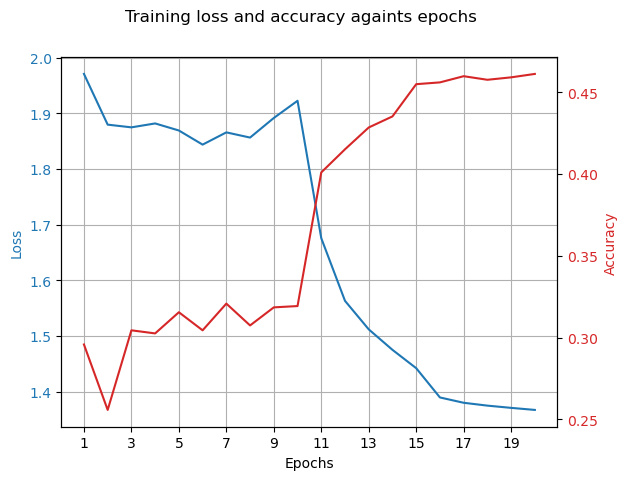

In [35]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-step.pdf")

## Exponential scheduler

In [18]:
model3 = Net()
model3.to(device)

optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.95)  # a_k *= 0.95**k

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()
for epoch in range(max_epochs):
    ## train
    loss_train, acc_train = train(model3, device, trainloader, criterion, optimizer)
    print(f"Epoch: {epoch+1}, Learning rate: {get_lr(optimizer):.6f}")
    print(f"Training - Loss: {loss_train:.4f}, Accuracy: {acc_train:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
    losses.append(loss_train)
    scheduler.step()
    ## test
    loss_test, acc_test = test(model3, device, criterion, testloader)
    accs.append(acc_test)
    print(f"Test - Loss: {loss_test:.4f}, Accuracy: {acc_test:.2f}")
    _epoch_time = time.time()
print(f"Runtime: {(time.time() - _start):.2f} seconds")

es1_loss_acc["SGD-Exp"] = [losses, accs]

test_class(model3, device, criterion, testloader, classes)

Epoch: 1, Learning rate: 0.010000
Training - Loss: 1.9209, Accuracy: 0.29, Runtime: 9.83
Test - Loss: 1.5917, Accuracy: 0.41
Epoch: 2, Learning rate: 0.009500
Training - Loss: 1.3767, Accuracy: 0.50, Runtime: 9.68
Test - Loss: 1.2014, Accuracy: 0.57
Epoch: 3, Learning rate: 0.009025
Training - Loss: 1.1243, Accuracy: 0.60, Runtime: 9.57
Test - Loss: 1.1151, Accuracy: 0.61
Epoch: 4, Learning rate: 0.008574
Training - Loss: 0.9357, Accuracy: 0.67, Runtime: 9.68
Test - Loss: 1.1153, Accuracy: 0.62
Epoch: 5, Learning rate: 0.008145
Training - Loss: 0.7547, Accuracy: 0.74, Runtime: 9.38
Test - Loss: 1.0088, Accuracy: 0.66
Epoch: 6, Learning rate: 0.007738
Training - Loss: 0.5730, Accuracy: 0.80, Runtime: 9.61
Test - Loss: 1.0816, Accuracy: 0.66
Epoch: 7, Learning rate: 0.007351
Training - Loss: 0.3990, Accuracy: 0.86, Runtime: 9.29
Test - Loss: 1.2460, Accuracy: 0.65
Epoch: 8, Learning rate: 0.006983
Training - Loss: 0.2881, Accuracy: 0.90, Runtime: 9.39
Test - Loss: 1.3279, Accuracy: 0.65


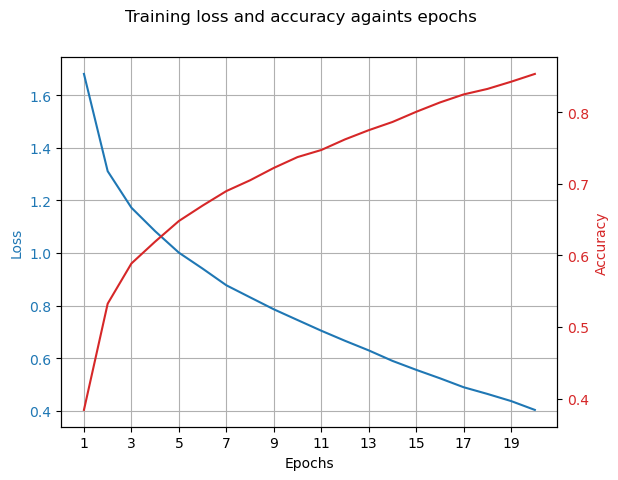

In [51]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-exp.pdf")

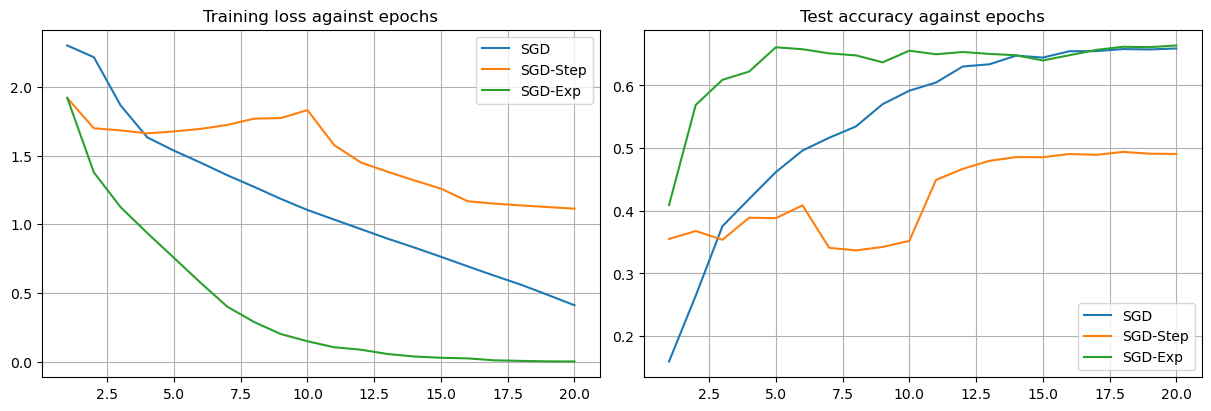

In [19]:
multiple_diagnostic(es1_loss_acc, max_epochs)
plt.savefig("./plots/cifar10-opt-diagnostic.pdf")

# Excercise 2

In [9]:
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

In [10]:
transform = transforms.Compose([
    # geometric transforms
    # transforms.RandomRotation(degrees=20),  # rotates the image randomly within a range of -20 to 20 degrees
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomHorizontalFlip(p=0.5),  # flips the image horizontally with a 50% probability
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # randomly crops between 80% and 100% of the original image and resizes to 32x32
    # color transforms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # randomly changes the brightness, contrast, saturation, and hue of the image
    transforms.RandomGrayscale(p=0.1),  # converts the image to grayscale with a 10% probability
    # noise injection
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),  # applies a Gaussian blur with a specified range for sigma
    # normalization
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # randomly selects a rectangle region in an image and erases its pixels
    transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

In [11]:
# plot real and augmented images
from torchvision.utils import make_grid

to_show = 20  # take the first images
imgs = torch.stack((*[non_augmented[i][0] for i in range(to_show)],
                    *[trainset[i][0] for i in range(to_show)]))
grid = make_grid(imgs, nrow=to_show)

image = transforms.ToPILImage()(grid)
image.show()
image.save("transforms.png")

# Excercise 3

In [15]:
import torchvision.models as models

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

My Net

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
notransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

In [10]:
# con troppe trasformazioni va lento perché le applica online
transform = transforms.Compose([
    # geometric transforms
    # transforms.RandomRotation(degrees=20),  # rotates the image randomly within a range of -20 to 20 degrees
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomHorizontalFlip(p=0.5),  # flips the image horizontally with a 50% probability
    # transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # randomly crops between 80% and 100% of the original image and resizes to 32x32
    # color transforms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # randomly changes the brightness, contrast, saturation, and hue of the image
    # transforms.RandomGrayscale(p=0.1),  # converts the image to grayscale with a 10% probability
    # noise injection
    # transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.8)),  # applies a Gaussian blur with a specified range for sigma
    # normalization
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # randomly selects a rectangle region in an image and erases its pixels
    transforms.ToTensor(),
    # transforms.Resize(224),  # for alexnet
    transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Resize(224),  # for alexnet
     transforms.Normalize(mean, std)])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [15]:

resnet18 = models.resnet18()
vgg16 = models.vgg16()

In [20]:
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()
for epoch in range(20):
    loss_k, acc_k = train(model, device, criterion, optimizer, trainloader)
    losses.append(loss_k)
    accs.append(acc_k)
    print(f"Epoch: {epoch}, Loss: {loss_k:.4f}, Accuracy: {acc_k:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
    _epoch_time = time.time()
print(f"Runtime: {(time.time() - _start):.2f} seconds")
torch.save(model.state_dict(), 'net_augmented1.pth')

# es1_loss_acc["SGD"] = [losses, accs]

test_class(model, device, criterion, testloader)

Epoch: 0, Loss: 2.2560, Accuracy: 0.15, Runtime: 13.69
Epoch: 1, Loss: 1.9195, Accuracy: 0.31, Runtime: 13.73
Epoch: 2, Loss: 1.6988, Accuracy: 0.39, Runtime: 13.91
Epoch: 3, Loss: 1.5789, Accuracy: 0.44, Runtime: 13.71
Epoch: 4, Loss: 1.5040, Accuracy: 0.46, Runtime: 13.76
Epoch: 5, Loss: 1.4401, Accuracy: 0.49, Runtime: 13.66
Epoch: 6, Loss: 1.3854, Accuracy: 0.51, Runtime: 13.72
Epoch: 7, Loss: 1.3348, Accuracy: 0.53, Runtime: 13.64
Epoch: 8, Loss: 1.2886, Accuracy: 0.55, Runtime: 13.61
Epoch: 9, Loss: 1.2479, Accuracy: 0.56, Runtime: 13.58
Epoch: 10, Loss: 1.2126, Accuracy: 0.58, Runtime: 13.71
Epoch: 11, Loss: 1.1827, Accuracy: 0.59, Runtime: 13.62
Epoch: 12, Loss: 1.1538, Accuracy: 0.60, Runtime: 13.63
Epoch: 13, Loss: 1.1251, Accuracy: 0.61, Runtime: 13.63
Epoch: 14, Loss: 1.1103, Accuracy: 0.61, Runtime: 13.63
Epoch: 15, Loss: 1.0878, Accuracy: 0.62, Runtime: 13.57
Epoch: 16, Loss: 1.0643, Accuracy: 0.63, Runtime: 13.61
Epoch: 17, Loss: 1.0469, Accuracy: 0.64, Runtime: 13.62
Ep

Train AlexNet

In [31]:
alexnet = models.alexnet(weights="DEFAULT")
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)
alexnet.to(device)
count_trainable_parameters(alexnet)

57044810

In [32]:
# freeze layers
for param in alexnet.parameters():
    param.requires_grad = False

# si lascia modificabili quelli del layer aggiunto
alexnet.classifier[6].weight.requires_grad = True
alexnet.classifier[6].bias.requires_grad = True
count_trainable_parameters(alexnet)  # 4096 * 10 + 1 (bias)

40970

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()
for epoch in range(6):
    loss_k, acc_k = train(alexnet, device, criterion, optimizer, trainloader)
    losses.append(loss_k)
    accs.append(acc_k)
    print(f"Epoch: {epoch}, Loss: {loss_k:.4f}, Accuracy: {acc_k:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
    _epoch_time = time.time()
print(f"Runtime: {(time.time() - _start):.2f} seconds")
# torch.save(alexnet.state_dict(), 'alexnet_cifar10.pth')

# es1_loss_acc["SGD"] = [losses, accs]

test_class(alexnet, device, criterion, testloader)

Epoch: 0, Loss: 0.8689, Accuracy: 0.69, Runtime: 32.80
Epoch: 1, Loss: 0.7460, Accuracy: 0.74, Runtime: 33.39
Epoch: 2, Loss: 0.7135, Accuracy: 0.75, Runtime: 38.88
Epoch: 3, Loss: 0.6961, Accuracy: 0.75, Runtime: 45.16
Epoch: 4, Loss: 0.6938, Accuracy: 0.76, Runtime: 37.61
Epoch: 5, Loss: 0.6850, Accuracy: 0.76, Runtime: 37.37
Runtime: 225.22 seconds
Accuracy for class: plane is 85.0 %
Accuracy for class: car   is 89.6 %
Accuracy for class: bird  is 75.4 %
Accuracy for class: cat   is 67.0 %
Accuracy for class: deer  is 71.4 %
Accuracy for class: dog   is 81.5 %
Accuracy for class: frog  is 87.1 %
Accuracy for class: horse is 86.7 %
Accuracy for class: ship  is 88.8 %
Accuracy for class: truck is 87.7 %
